In [261]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
#import plotly.express as px
from statsmodels.graphics import tsaplots
from scipy.stats import boxcox
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from yahoo_fin.stock_info import get_data
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from arch import arch_model
from statsmodels.tsa.ar_model import AutoReg


# Getting the data

We are using the python lybrary "yahoo_fin" to get the data from the yahoo api

In [262]:
df = get_data("^GSPC")
df.to_csv("df.csv")
df = df.drop('ticker', axis=1)
df.head()

,open,high,low,close,adjclose,volume
1970-03-25,0.0,91.070000,88.110001,89.769997,89.769997,17500000
1970-03-26,0.0,90.650002,89.180000,89.919998,89.919998,11350000
1970-03-30,0.0,90.410004,88.910004,89.629997,89.629997,9600000
1970-03-31,0.0,90.169998,88.849998,89.629997,89.629997,8370000
1970-04-01,0.0,90.620003,89.300003,90.070000,90.070000,9810000


In [263]:
df.describe()


,open,high,low,close,adjclose,volume
count,13569.000000,13569.000000,13569.000000,13569.000000,13569.000000,1.356900e+04
mean,1033.781691,1062.938694,1049.903098,1056.843079,1056.843079,1.578163e+09
std,1132.438600,1118.390759,1105.708344,1112.445231,1112.445231,1.869618e+09
min,0.000000,63.230000,60.959999,62.279999,62.279999,6.650000e+06
25%,157.899994,158.490005,157.100006,157.979996,157.979996,8.100000e+07
50%,754.719971,758.289978,747.590027,754.719971,754.719971,4.715900e+08
75%,1396.670044,1404.140015,1386.390015,1397.109985,1397.109985,3.278240e+09
max,4804.509766,4818.620117,4780.979980,4796.560059,4796.560059,1.145623e+10


# Analyzing the time series
Now that we have the data we can start analyzing it
## Time series Plots

KeyboardInterrupt: 

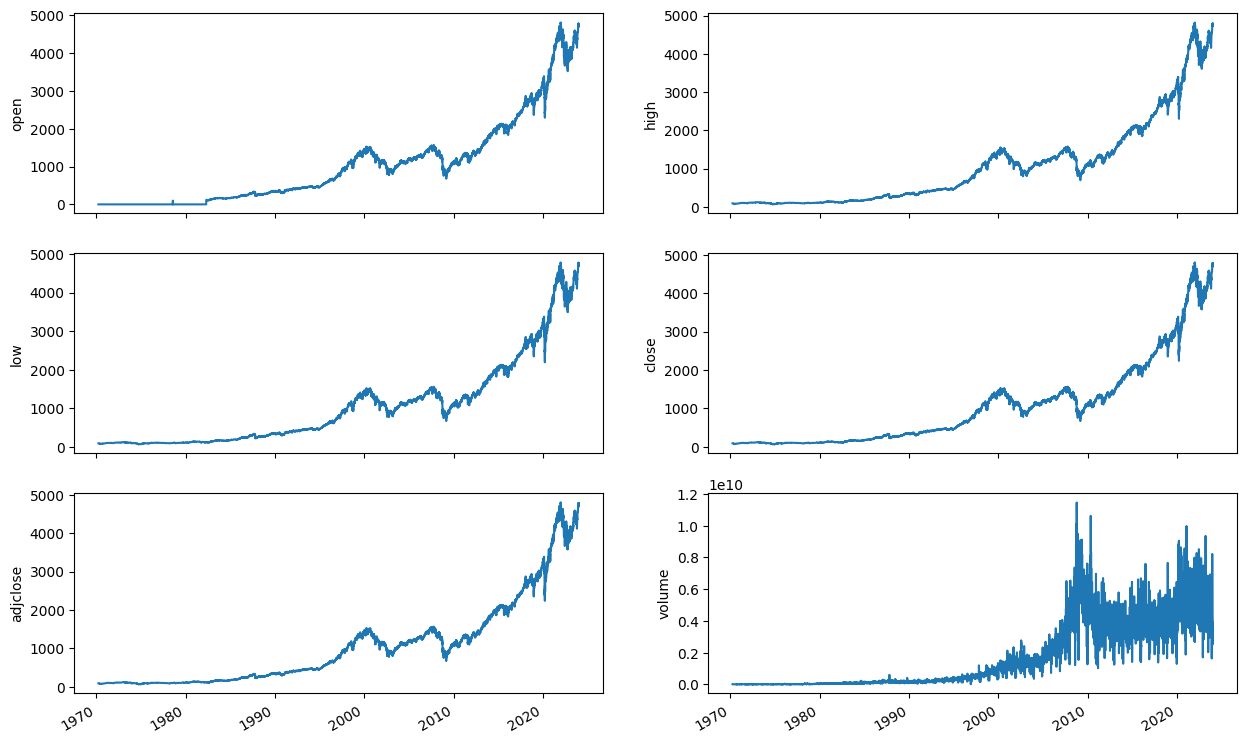

In [264]:
labels = df.columns.values

plt.figure(figsize=(15,10))
p = 1
for label in labels:
    plt.subplot(3,2,p)
    p +=1
    plt.plot(df.index,df[label])
    plt.ylabel(label)
    date_format = mdates.DateFormatter("%Y")
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

## Chossing variable to study

Because our data has multiple variables we need to decide on one to study we decided to use the variable "adjclose".

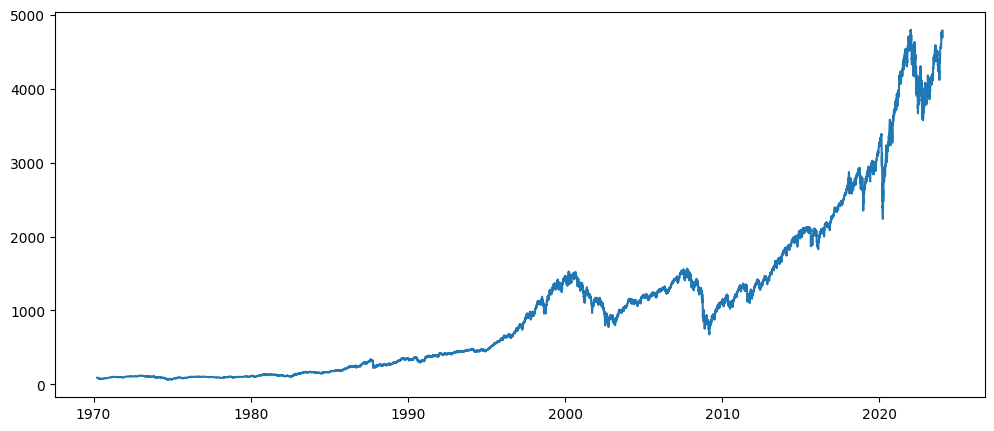

In [ ]:
var = 'adjclose'
plt.figure(figsize=(12,5))
plt.plot(df.index,df[var])
plt.show()

## Decomposing the time series

In [ ]:
def seasonal_decomposition(df, column_name):

    result_mul = seasonal_decompose(df[column_name], model='multiplicative', period=12, extrapolate_trend='freq')
    result_add = seasonal_decompose(df[column_name], model='additive', period=12, extrapolate_trend='freq')
    
    return result_mul, result_add

def plot_decompostion(df, column_name, decomposition):
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(df[column_name], label='Original TS')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(decomposition.seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residual')
    plt.legend(loc='best')
    plt.show()

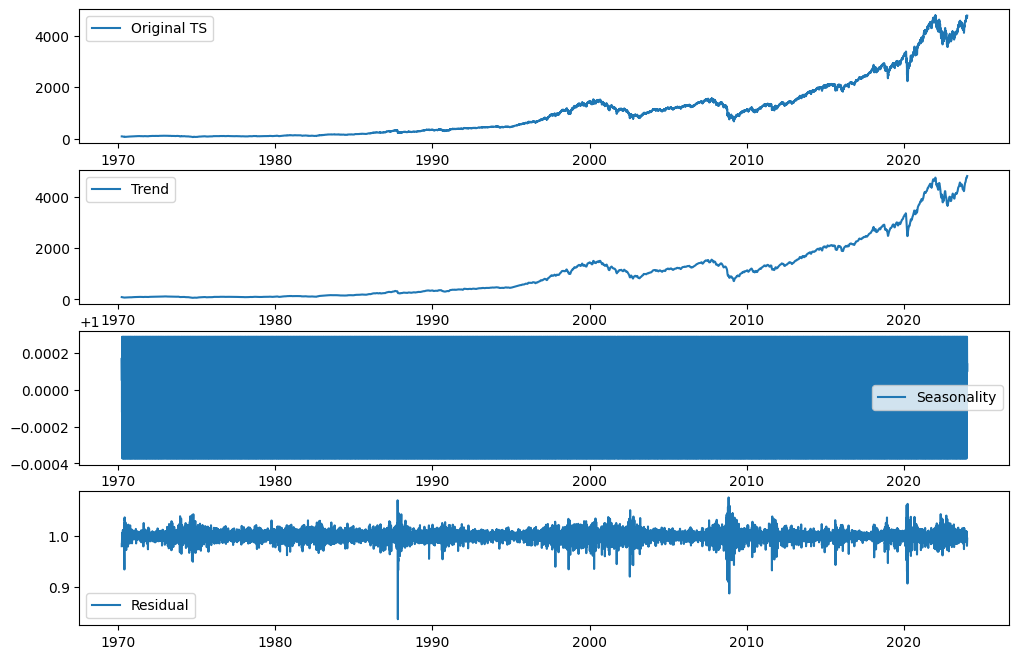

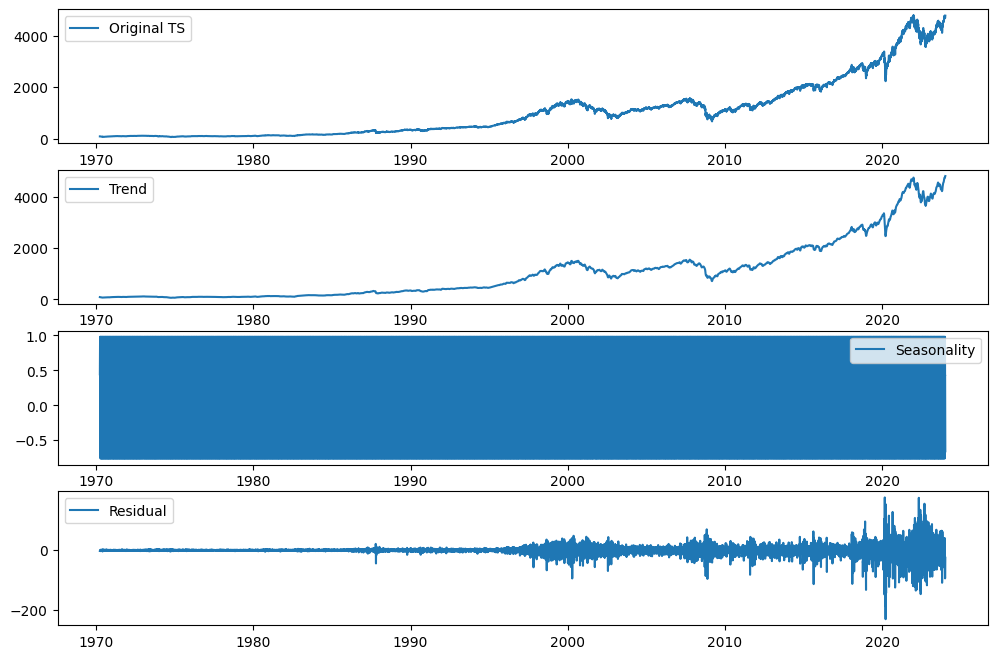

In [ ]:
result_mult, result_add = seasonal_decomposition(df,var)

plot_decompostion(df,var,result_mult)
plot_decompostion(df,var,result_add)


### Auto-correlation function of the residuals of the decomposition

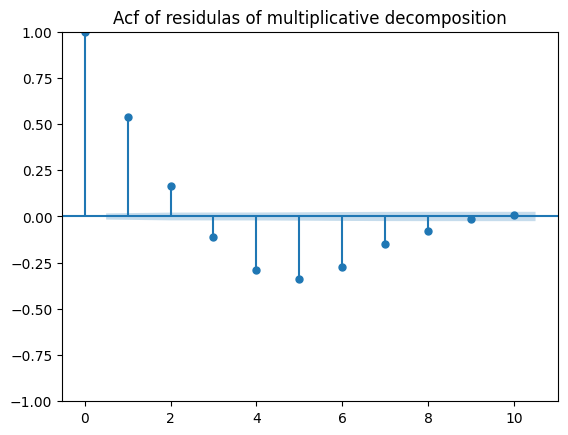

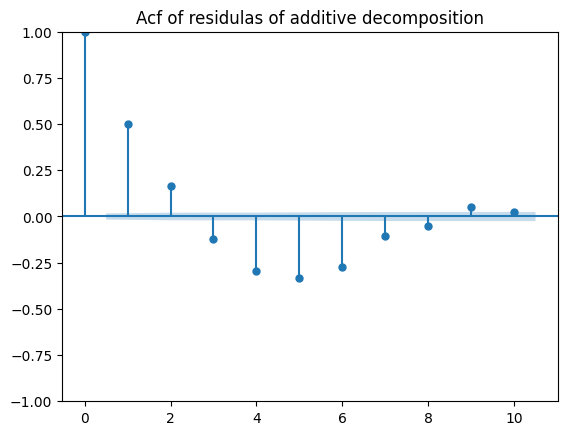

In [ ]:
fig = tsaplots.plot_acf(result_mult.resid, lags=10)
plt.title('Acf of residulas of multiplicative decomposition')
plt.show()

fig = tsaplots.plot_acf(result_add.resid, lags=10)
plt.title('Acf of residulas of additive decomposition')
plt.show()

## Lag plots

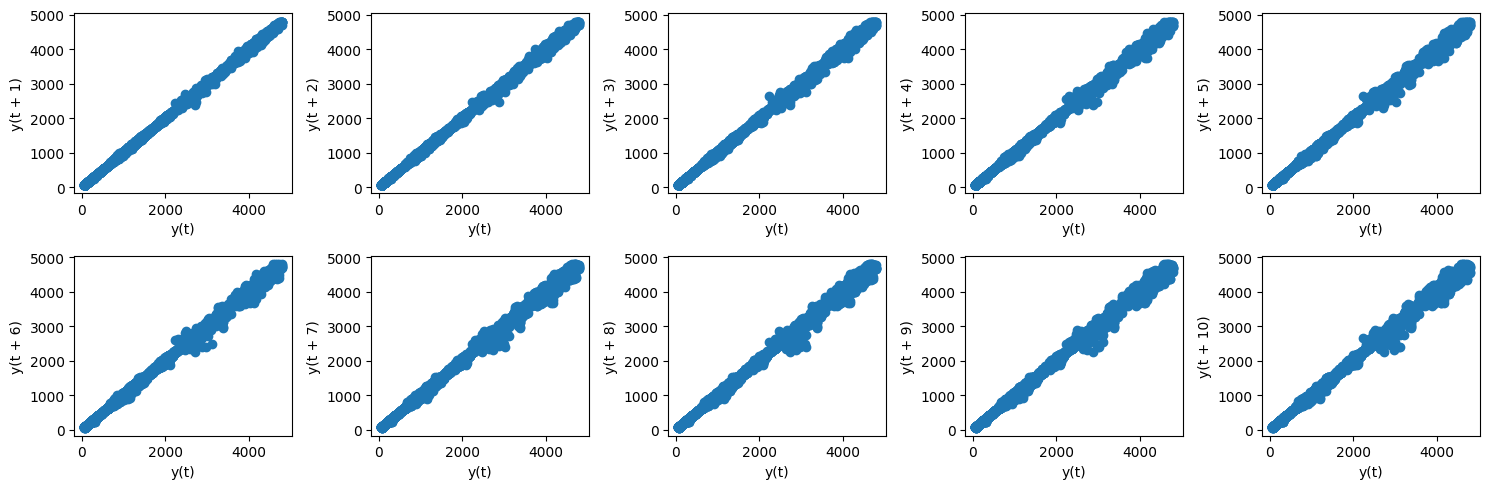

In [ ]:
plt.figure(figsize=(15,5))
for i in range(1,11):
    plt.subplot(2,5,i)
    pd.plotting.lag_plot(df[var],lag=i)

plt.tight_layout()
plt.show()


## ACF Plot

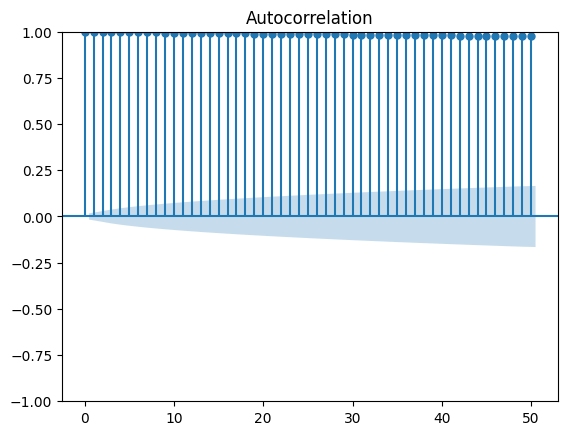

[1.         0.99943876 0.99890418 0.99835984 0.99783365 0.99731718
 0.99679317 0.99627671 0.99573488 0.99520821 0.99465882]


In [ ]:
acf= sm.tsa.acf(df[var],nlags=10)
fig = tsaplots.plot_acf(df[var], lags=50)
plt.show()
print(acf)

# Analysing the daily difference

In [ ]:
daily_diff = df.diff()
daily_diff = daily_diff.dropna()
daily_diff.describe()


,open,high,low,close,adjclose,volume
count,13568.000000,13568.000000,13568.000000,13568.000000,13568.000000,1.356800e+04
mean,0.350821,0.346383,0.344051,0.345938,0.345938,1.579788e+05
std,15.678189,13.588251,15.348829,17.219983,17.219983,4.461424e+08
min,-194.739990,-164.650146,-228.359863,-324.890137,-324.890137,-5.044220e+09
25%,-1.700005,-1.539978,-1.680002,-1.862579,-1.862579,-3.937750e+07
50%,0.000000,0.110001,0.190002,0.139999,0.139999,0.000000e+00
75%,2.969978,2.500000,2.869995,2.932526,2.932526,3.790000e+07
max,170.039795,148.979980,172.180176,230.380127,230.380127,4.637230e+09


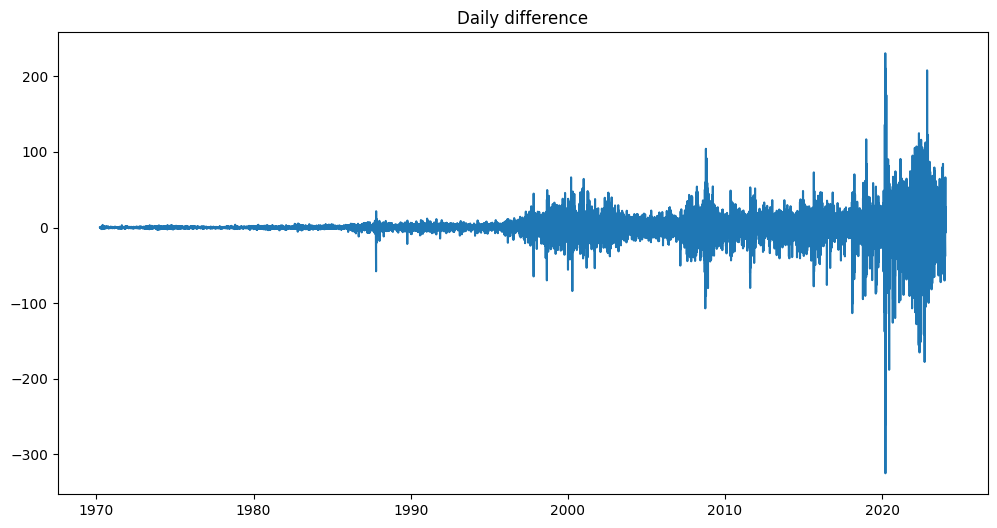

In [ ]:
plt.figure(figsize=(12,6))
#plt.scatter(monthly_diff.index,monthly_diff[var])
plt.plot(daily_diff.index,daily_diff[var])
plt.title('Daily difference')
plt.show()

## Check for stationary

In [ ]:
result = adfuller(daily_diff[var])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

if result[1] <= 0.05:
    print("The time series is stationary.\n\n")
else:
    print("The time series is non-stationary.\n\n")

result = kpss(daily_diff[var])
print('KPSS Statistic:', result[0])
print('p-value:', result[1])

if result[1] <= 0.05:
    print("The time series is non-stationary.")
else:
    print("The time series is stationary.")

ADF Statistic: -20.001388255174845
p-value: 0.0
Critical Values: {'1%': -3.4308335532641925, '5%': -2.861753707914063, '10%': -2.5668837518611642}
The time series is stationary.


KPSS Statistic: 0.7657239547510898
p-value: 0.01
The time series is non-stationary.


C:\Users\GODA\AppData\Local\Temp\ipykernel_2240\3128835151.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(daily_diff[var])


## ACF of daily differences

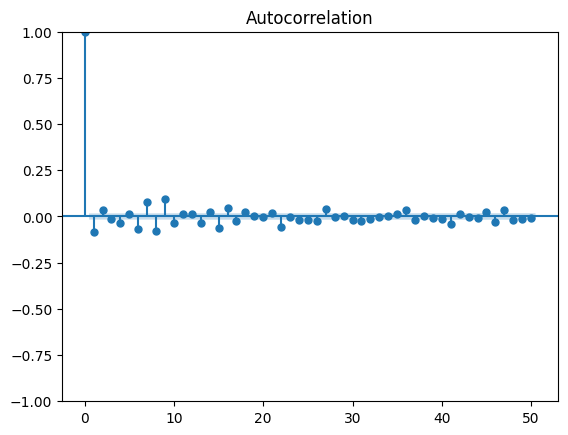

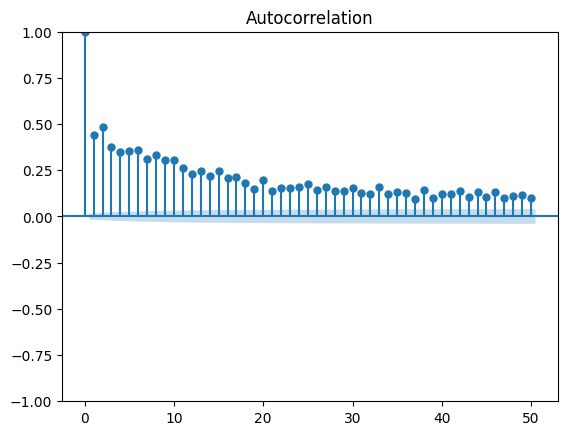

In [ ]:
tsaplots.plot_acf(daily_diff[var], lags=50)
plt.show()

returns_sqr = map(lambda x: x*x , daily_diff[var])

tsaplots.plot_acf(list(returns_sqr), lags=50)
plt.show()

# tsaplots.plot_pacf(daily_diff[var],lags=50)
# plt.show()

## Lag plots of daily differences

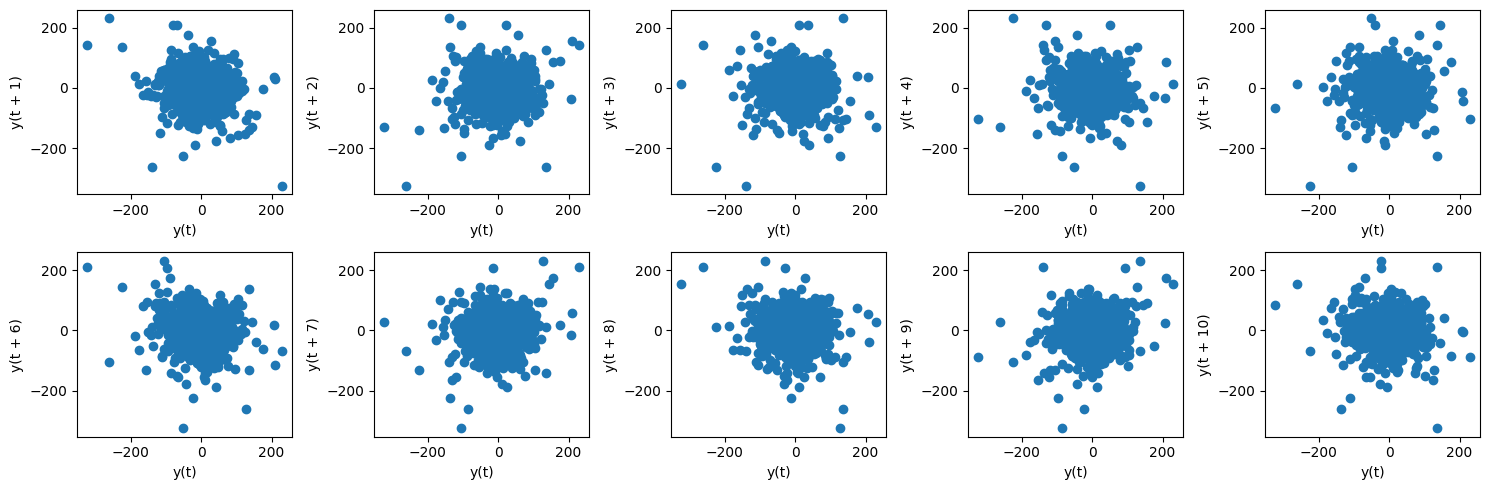

In [ ]:
plt.figure(figsize=(15,5))
for i in range(1,11):
    plt.subplot(2,5,i)
    pd.plotting.lag_plot(daily_diff[var],lag=i)

plt.tight_layout()
plt.show()

## Decomposition of daily differences

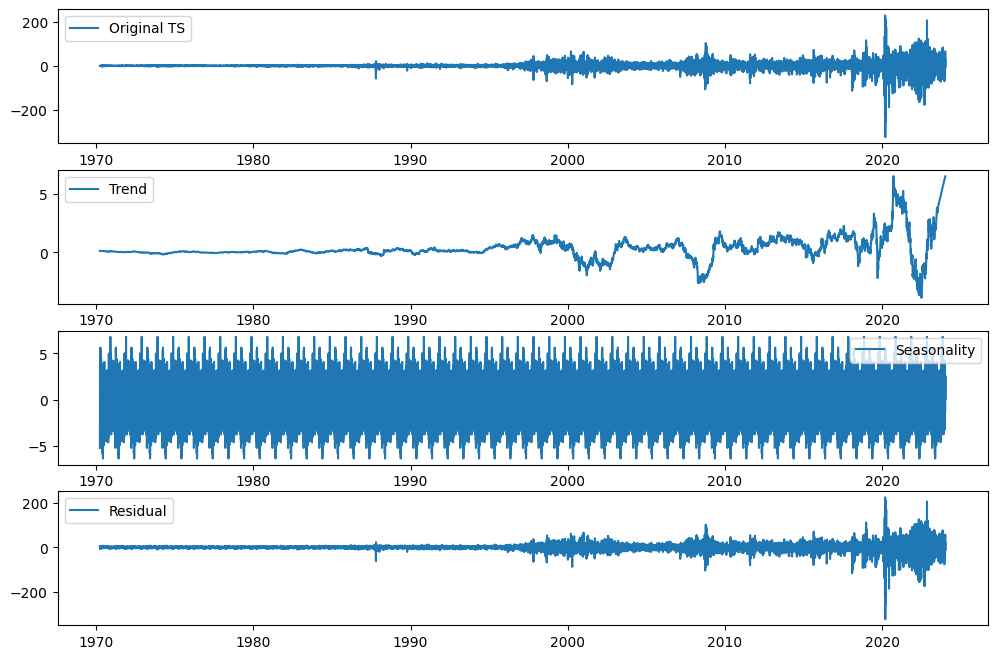

In [ ]:
result_add = seasonal_decompose(daily_diff[var], model='additive',period=252, extrapolate_trend='freq' )

plot_decompostion(daily_diff,var,result_add)

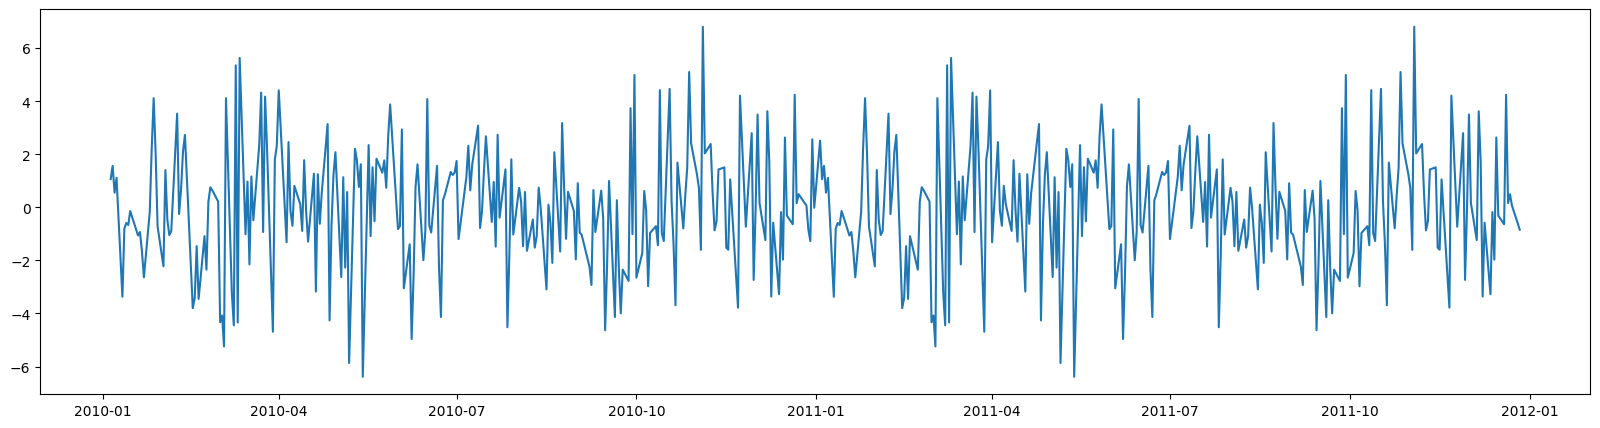

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(result_add.seasonal[10040:10540], label='Residual')
plt.show()

# Analysing the data monthly

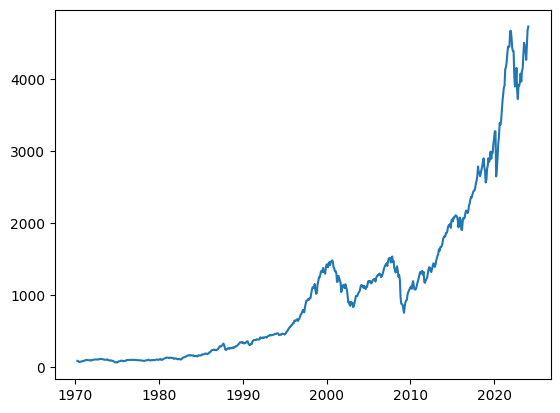

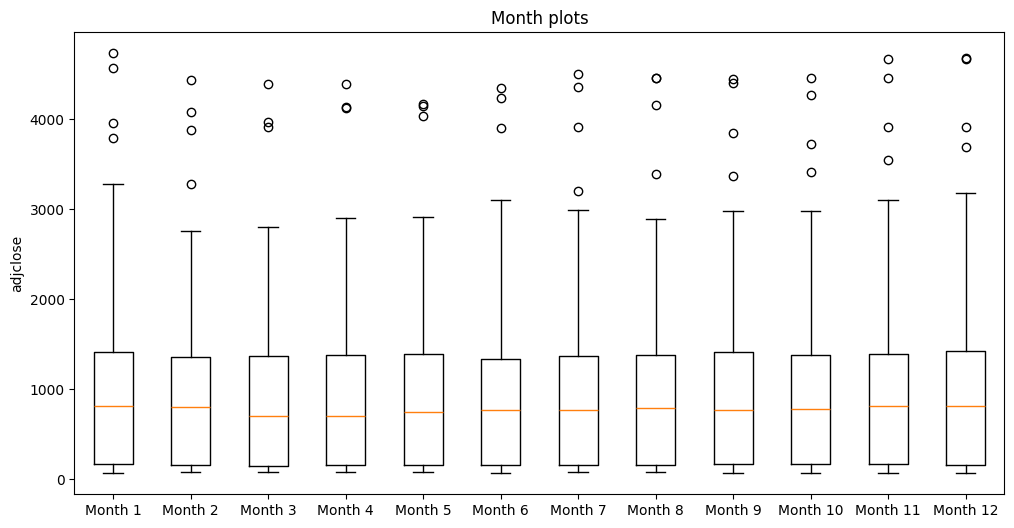

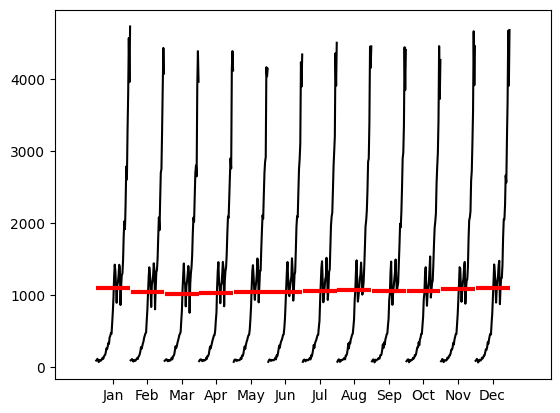

In [ ]:
monthly_data = df.resample('M').mean()

plt.plot(monthly_data.index,monthly_data[var])
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))

data_boxplots = [group[var].values for month, group in monthly_data.groupby(monthly_data.index.month)]

ax.boxplot(data_boxplots, labels=[f'Month {month}' for month in range(1, 13)])
ax.set_ylabel(var)
ax.set_title('Month plots')

plt.show()

fig = sm.graphics.tsa.month_plot(monthly_data[var])
plt.show()


## The evolution of the monthly difference

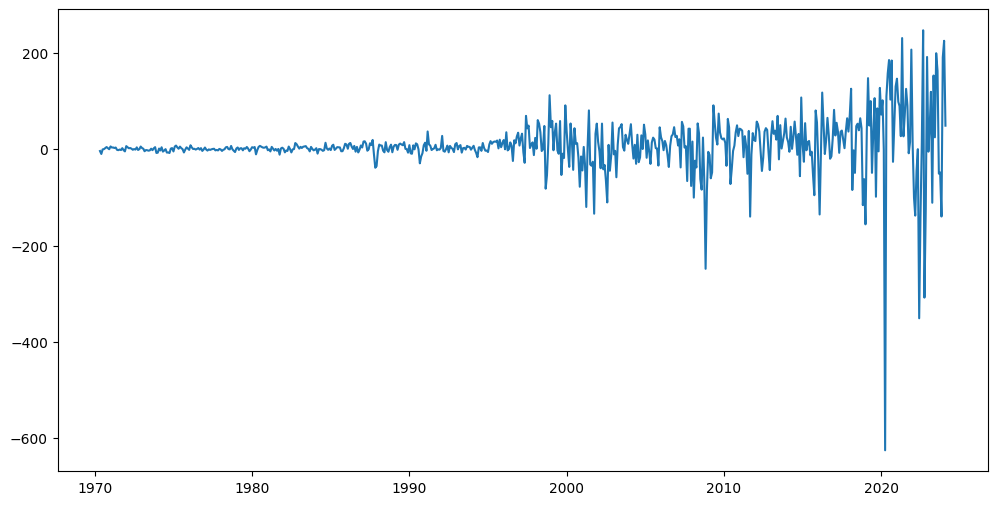

In [ ]:
monthly_diff = monthly_data.diff()

plt.figure(figsize=(12,6))
#plt.scatter(monthly_diff.index,monthly_diff[var])
plt.plot(monthly_diff.index,monthly_diff[var])
plt.show()

# Analysing the box-cox transformation

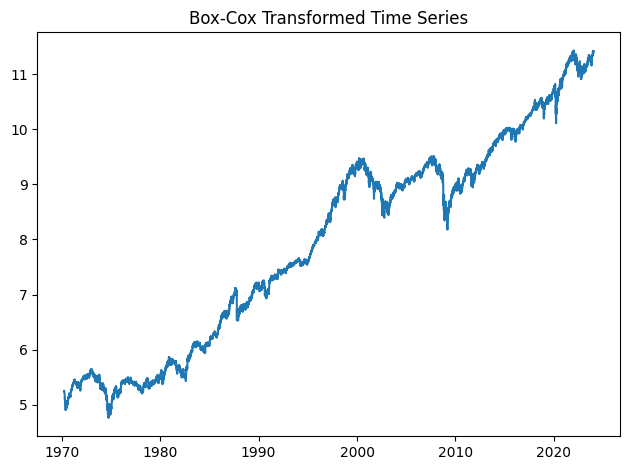

Optimal lambda value: 0.06724454461224579


In [ ]:
transformed_values, lambda_value = boxcox(df[var])

plt.plot(df.index, transformed_values)
plt.title('Box-Cox Transformed Time Series')

plt.tight_layout()
plt.show()

print(f'Optimal lambda value: {lambda_value}')

## Decomposition of box-cox transformation

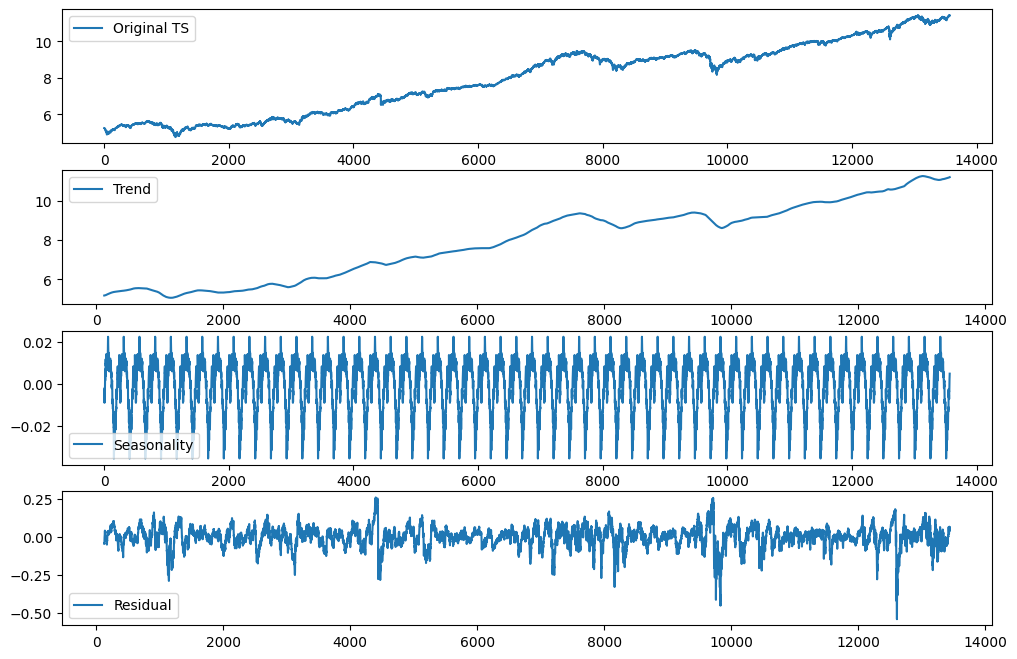

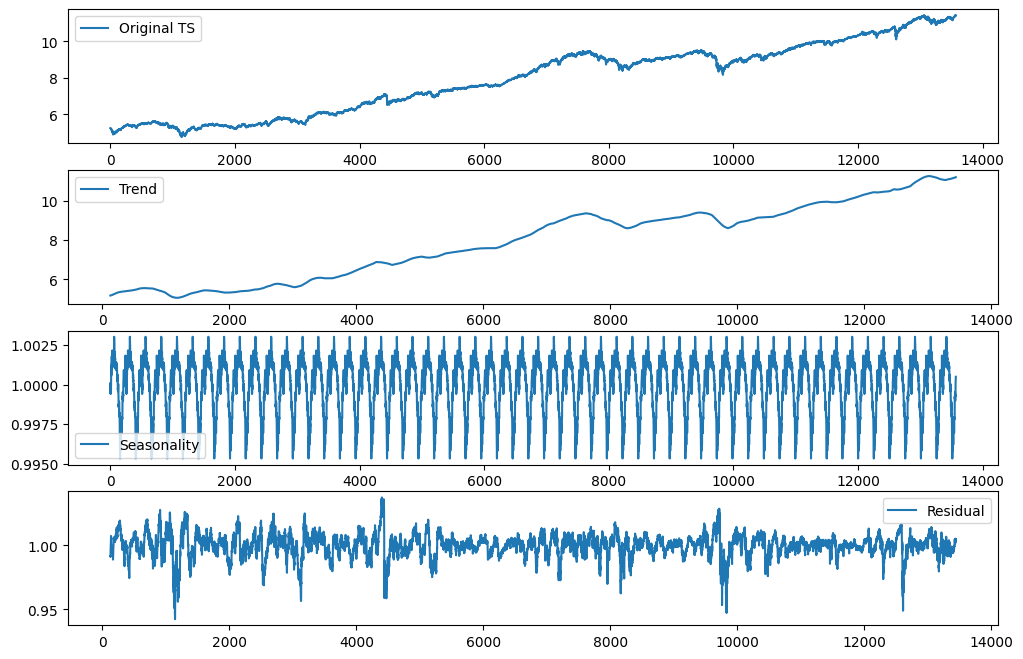

In [ ]:
decompose_add=seasonal_decompose(transformed_values, model='additive', period=252)
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(transformed_values, label='Original TS')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decompose_add.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decompose_add.seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decompose_add.resid, label='Residual')
plt.legend(loc='best')

plt.show()

decompose_mult=seasonal_decompose(transformed_values, model='multiplicative', period=252)
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(transformed_values, label='Original TS')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decompose_mult.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decompose_mult.seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decompose_mult.resid, label='Residual')
plt.legend(loc='best')

plt.show()

## Lag plots of box-cox transformation

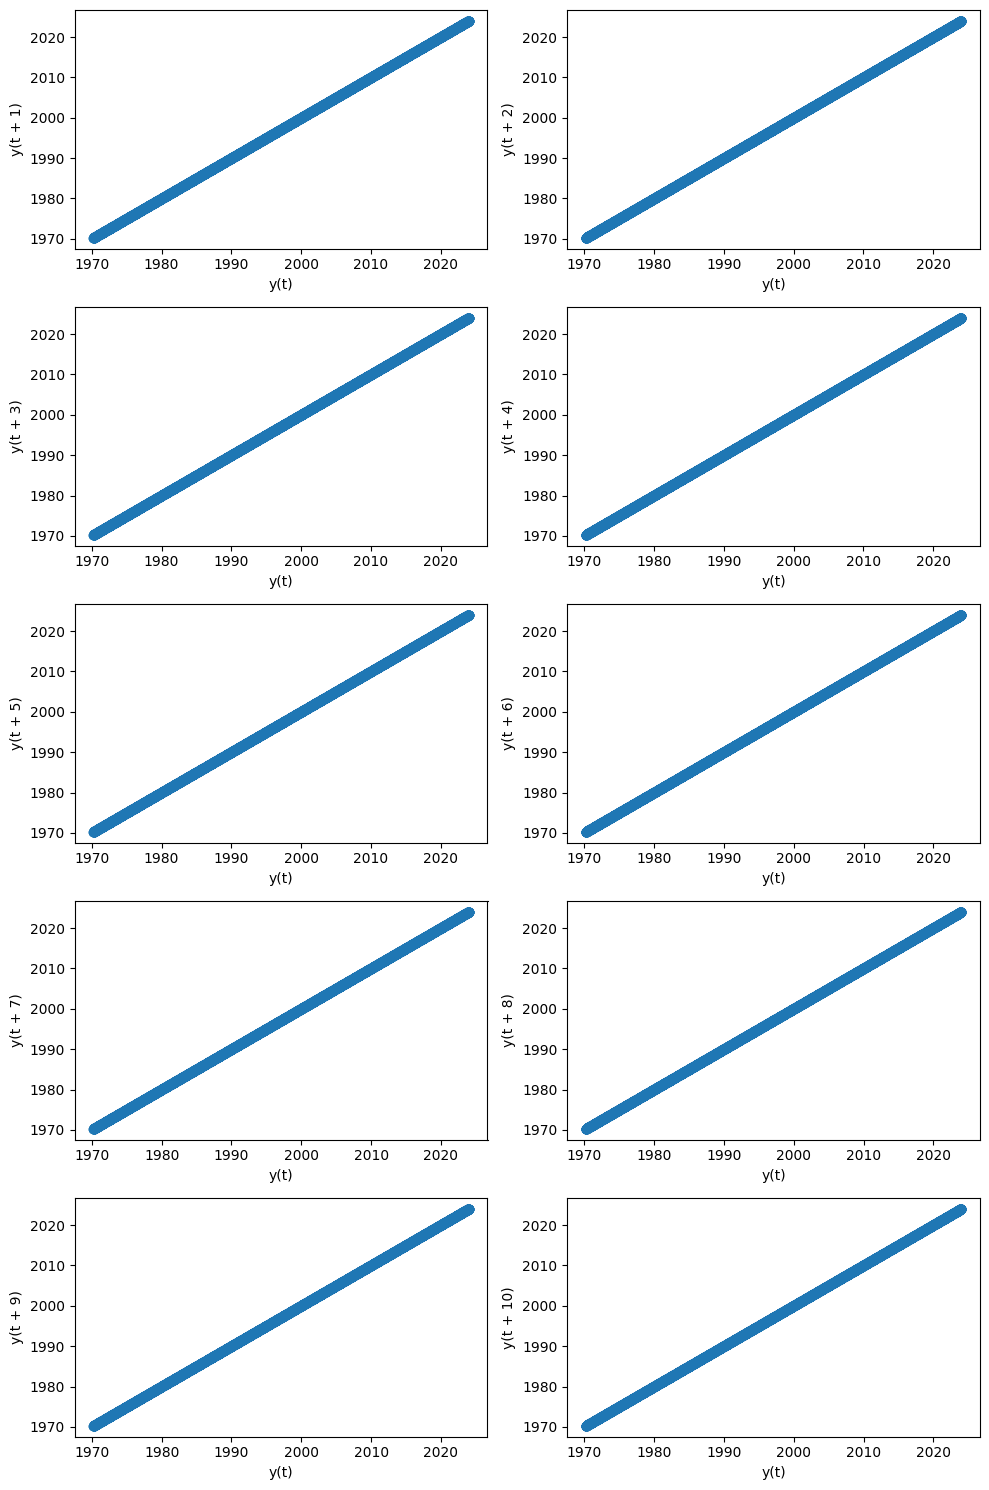

In [ ]:
transformed_df = pd.Series(df.index,transformed_values)

plt.figure(figsize=(10,15))
for i in range(1,11):
    plt.subplot(5,2,i)
    pd.plotting.lag_plot(transformed_df,lag=i)

plt.tight_layout()
plt.show()

## ACF of box-cox transformation

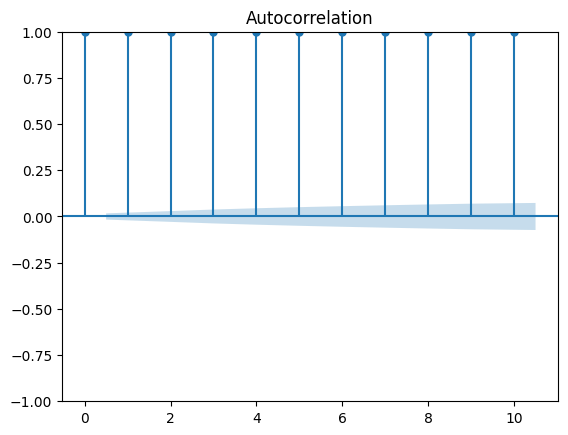

In [ ]:
acf= sm.tsa.acf(transformed_values)
fig = tsaplots.plot_acf(transformed_values, lags=10)
plt.show()

In [ ]:
daily_diff.describe()

,open,high,low,close,adjclose,volume
count,13568.000000,13568.000000,13568.000000,13568.000000,13568.000000,1.356800e+04
mean,0.350821,0.346383,0.344051,0.345938,0.345938,1.579788e+05
std,15.678189,13.588251,15.348829,17.219983,17.219983,4.461424e+08
min,-194.739990,-164.650146,-228.359863,-324.890137,-324.890137,-5.044220e+09
25%,-1.700005,-1.539978,-1.680002,-1.862579,-1.862579,-3.937750e+07
50%,0.000000,0.110001,0.190002,0.139999,0.139999,0.000000e+00
75%,2.969978,2.500000,2.869995,2.932526,2.932526,3.790000e+07
max,170.039795,148.979980,172.180176,230.380127,230.380127,4.637230e+09


# Model

In [311]:
periods = 2
returns = df['adjclose'].pct_change(periods=periods)
returns = returns[periods:] *100
print(returns)
returns_sqr = list(map(lambda x:x*x,returns))

1970-03-30   -0.155953
1970-03-31   -0.322510
1970-04-01    0.490910
1970-04-02    0.178516
1970-04-03   -0.754969
                ...   
2024-01-04   -1.141721
2024-01-05   -0.160895
2024-01-08    1.596608
2024-01-09    1.261587
2024-01-10    0.417970
Name: adjclose, Length: 13567, dtype: float64


Returns


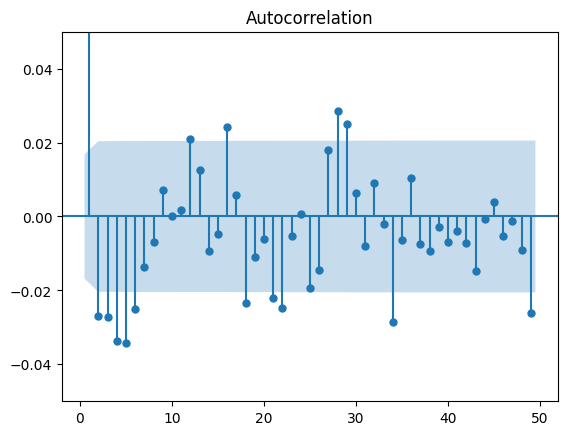

[ 1.00000000e+00  4.83345397e-01 -2.70283429e-02 -2.72604739e-02
 -3.38194141e-02 -3.43211833e-02 -2.49927271e-02 -1.37816205e-02
 -6.79647221e-03  7.11460060e-03  2.19612172e-04]


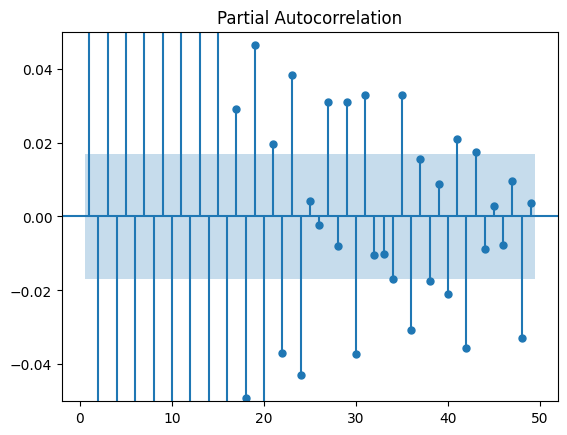

[ 1.          0.48338103 -0.34017355  0.22825335 -0.21417183  0.14619462
 -0.14335123  0.11250377 -0.10515546  0.10667415 -0.11077601]


In [312]:
print("Returns")
acf= sm.tsa.acf(returns,nlags=10)
fig = tsaplots.plot_acf(returns, lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(acf)

pacf= sm.tsa.pacf(returns,nlags=10)
fig = tsaplots.plot_pacf(returns, lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(pacf)

Returns square


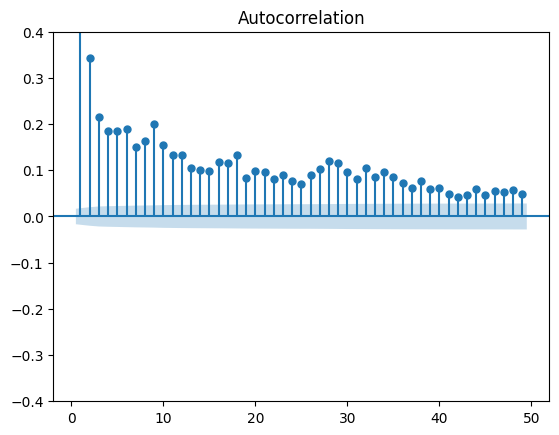

[1.         0.45930498 0.34223888 0.21627567 0.18397577 0.1845371
 0.18899767 0.15084209 0.16432618 0.19974323 0.15552784]


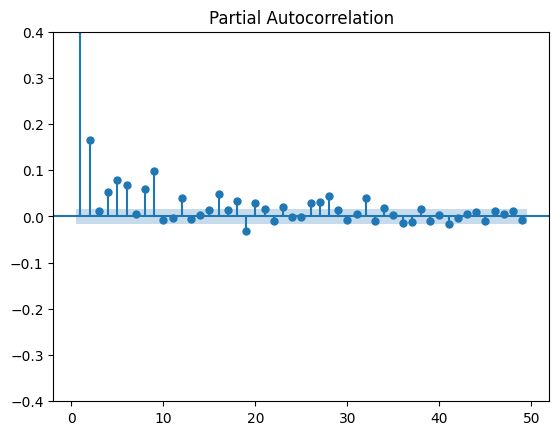

[ 1.          0.45933884  0.16640794  0.01150072  0.05329252  0.07839278
  0.06806706  0.0053921   0.05893027  0.09953667 -0.00793688]


In [313]:
print("Returns square")
acf= sm.tsa.acf(returns_sqr,nlags=10)
fig = tsaplots.plot_acf(returns_sqr, lags=range(1,50))
plt.ylim(-0.4,0.4)
plt.show()
print(acf)

pacf= sm.tsa.pacf(returns_sqr,nlags=10)
fig = tsaplots.plot_pacf(returns_sqr, lags=range(1,50))
plt.ylim(-0.4,0.4)
plt.show()
print(pacf)

c:\Users\GODA\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


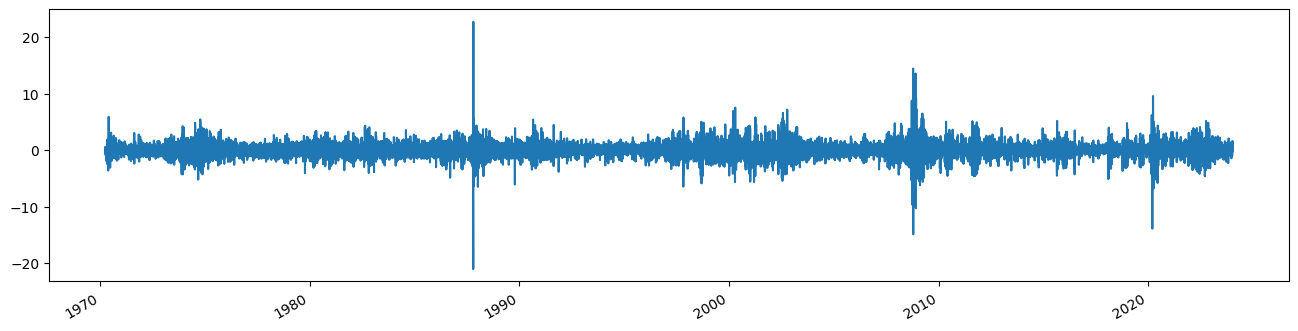

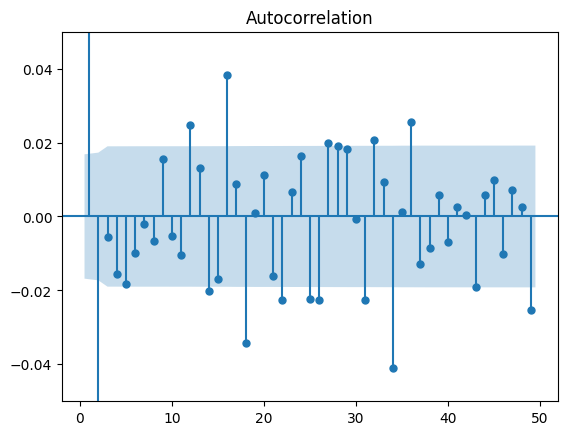

[ 1.          0.16438474 -0.33114793 -0.00549404 -0.01560537 -0.01816534
 -0.00990361 -0.00213902 -0.0067368   0.01559631 -0.00527911]


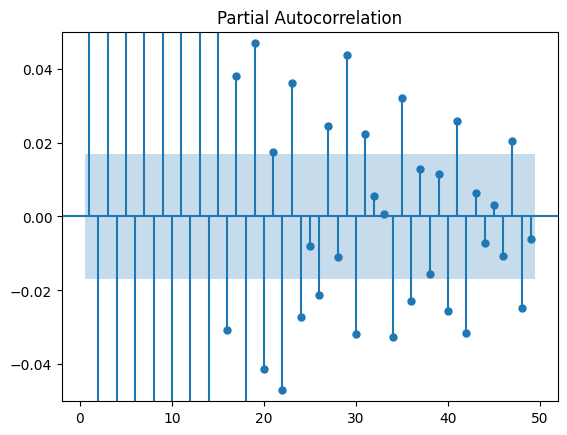

[ 1.          0.16439686 -0.36817346  0.15399768 -0.21042589  0.11375718
 -0.14265559  0.09430631 -0.11098341  0.10642538 -0.11460308]


In [314]:
model_ar = AutoReg(returns,lags=1)
result = model_ar.fit()

plt.figure(figsize=(16, 4))
result.resid.plot()
plt.show()

acf= sm.tsa.acf(result.resid,nlags=10)
fig = tsaplots.plot_acf(result.resid, lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(acf)

pacf= sm.tsa.pacf(result.resid,nlags=10)
fig = tsaplots.plot_pacf(result.resid, lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(pacf)

Iteration:      1,   Func. Count:      5,   Neg. LLF: 137303.45110849995
Iteration:      2,   Func. Count:     14,   Neg. LLF: 5532315.005985668
Iteration:      3,   Func. Count:     20,   Neg. LLF: 23492.417225042296
Iteration:      4,   Func. Count:     26,   Neg. LLF: 23241.078788191466
Iteration:      5,   Func. Count:     30,   Neg. LLF: 23241.07641586902
Iteration:      6,   Func. Count:     34,   Neg. LLF: 23241.07641505302
Optimization terminated successfully    (Exit mode 0)
            Current function value: 23241.07641505302
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 6


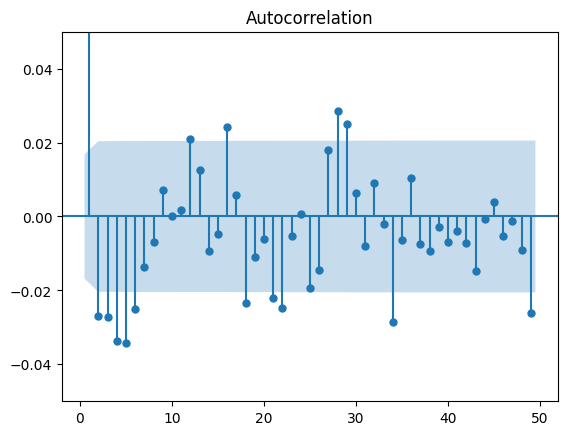

[ 1.00000000e+00  4.83345397e-01 -2.70283429e-02 -2.72604739e-02
 -3.38194141e-02 -3.43211833e-02 -2.49927271e-02 -1.37816205e-02
 -6.79647221e-03  7.11460060e-03  2.19612172e-04]


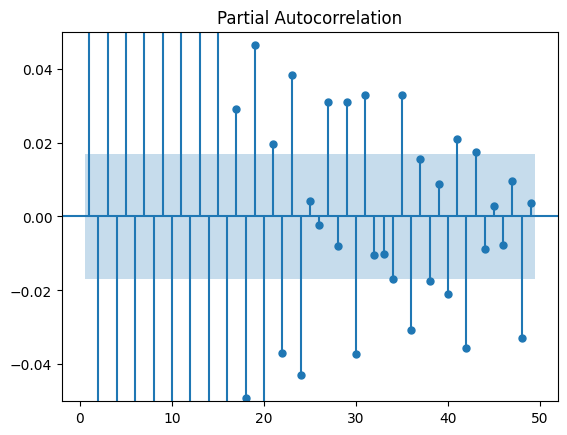

[ 1.          0.48338103 -0.34017355  0.22825335 -0.21417183  0.14619462
 -0.14335123  0.11250377 -0.10515546  0.10667415 -0.11077601]


In [315]:
model_arch = arch_model(returns,vol="ARCH",p=1)
result = model_arch.fit()

acf= sm.tsa.acf(result.resid,nlags=10)
tsaplots.plot_acf(result.resid, lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(acf)
pacf= sm.tsa.pacf(result.resid,nlags=10)
tsaplots.plot_pacf(result.resid,lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(pacf)

Iteration:      1,   Func. Count:      8,   Neg. LLF: 112240.43754575518
Iteration:      2,   Func. Count:     21,   Neg. LLF: 55977.94467294635
Iteration:      3,   Func. Count:     33,   Neg. LLF: 28470.645517557023
Iteration:      4,   Func. Count:     41,   Neg. LLF: 24684.3681132053
Iteration:      5,   Func. Count:     50,   Neg. LLF: 22420.79651757297
Iteration:      6,   Func. Count:     58,   Neg. LLF: 22263.869530096254
Iteration:      7,   Func. Count:     65,   Neg. LLF: 23656.211433574965
Iteration:      8,   Func. Count:     73,   Neg. LLF: 22910.332471272006
Iteration:      9,   Func. Count:     83,   Neg. LLF: 22223.28194905605
Iteration:     10,   Func. Count:     90,   Neg. LLF: 22211.315055859584
Iteration:     11,   Func. Count:     97,   Neg. LLF: 22210.691273859724
Iteration:     12,   Func. Count:    104,   Neg. LLF: 22210.2241288383
Iteration:     13,   Func. Count:    111,   Neg. LLF: 22210.114179977092
Iteration:     14,   Func. Count:    118,   Neg. LLF: 2221

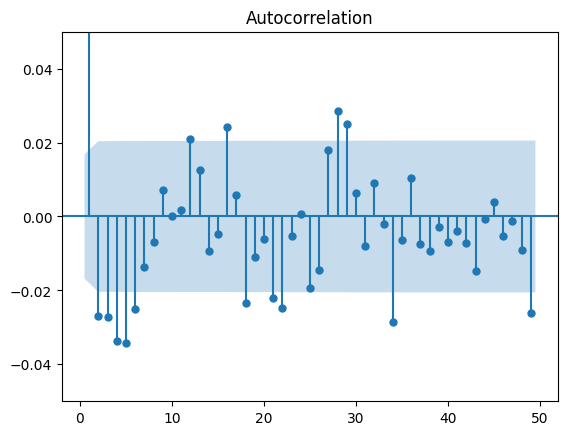

[ 1.00000000e+00  4.83345397e-01 -2.70283429e-02 -2.72604739e-02
 -3.38194141e-02 -3.43211833e-02 -2.49927271e-02 -1.37816205e-02
 -6.79647221e-03  7.11460060e-03  2.19612172e-04]


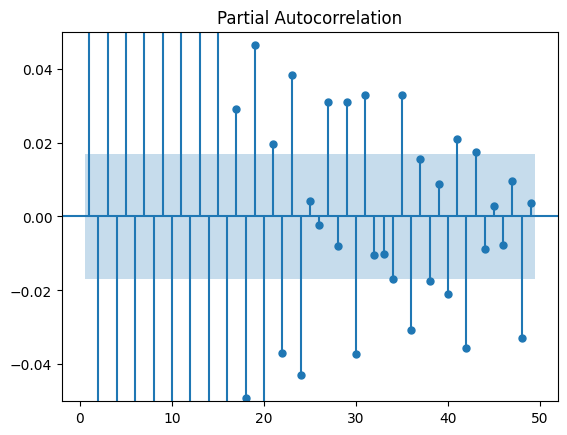

[ 1.          0.48338103 -0.34017355  0.22825335 -0.21417183  0.14619462
 -0.14335123  0.11250377 -0.10515546  0.10667415 -0.11077601]


In [316]:
model_garch = arch_model(returns,vol="GARCH",p=2,q=2)
result = model_garch.fit()

acf= sm.tsa.acf(result.resid,nlags=10)
tsaplots.plot_acf(result.resid, lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(acf)
pacf= sm.tsa.pacf(result.resid,nlags=10)
tsaplots.plot_pacf(result.resid,lags=range(1,50))
plt.ylim(-0.05,0.05)
plt.show()
print(pacf)

# Final model

In [317]:
cutoff_test = int(len(returns) * 0.8)
data_train = returns.iloc[:cutoff_test]
data_test = returns.iloc[cutoff_test:]


In [318]:
model_garch = arch_model(data_train,vol="GARCH",p=1,q=1)
result = model_garch.fit()
print(result.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 558353926066731.25


Iteration:      2,   Func. Count:     15,   Neg. LLF: 5862955060.121099
Iteration:      3,   Func. Count:     22,   Neg. LLF: 22460.956602165723
Iteration:      4,   Func. Count:     28,   Neg. LLF: 19019.597749738867
Iteration:      5,   Func. Count:     35,   Neg. LLF: 19083.09952381922
Iteration:      6,   Func. Count:     41,   Neg. LLF: 18163.12184674065
Iteration:      7,   Func. Count:     47,   Neg. LLF: 18145.157181710332
Iteration:      8,   Func. Count:     52,   Neg. LLF: 18144.745253682653
Iteration:      9,   Func. Count:     57,   Neg. LLF: 18144.712298597795
Iteration:     10,   Func. Count:     62,   Neg. LLF: 18144.705399895058
Iteration:     11,   Func. Count:     67,   Neg. LLF: 18144.705381046468
Iteration:     12,   Func. Count:     71,   Neg. LLF: 18144.705381046148
Optimization terminated successfully    (Exit mode 0)
            Current function value: 18144.705381046468
            Iterations: 12
            Function evaluations: 71
            Gradient evalua

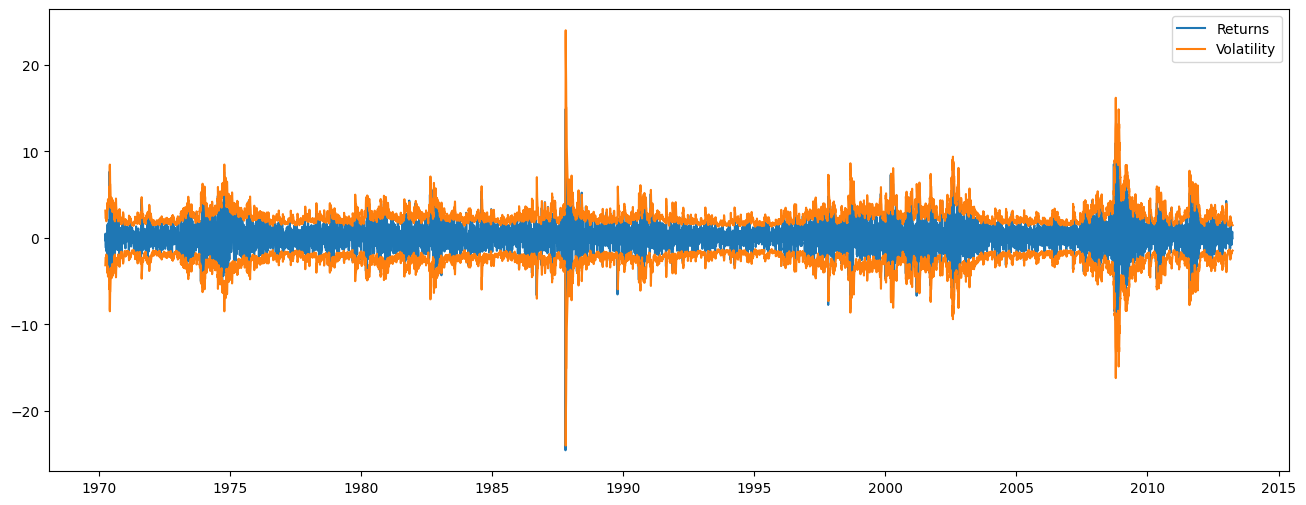

In [319]:
plt.figure(figsize=(16, 6))
plt.plot(data_train, label='Returns')
plt.plot(result.conditional_volatility * 2, label='Volatility',color = 'C1')
plt.plot(result.conditional_volatility * -2,color = 'C1')
plt.legend()
plt.show()

              h.0001    h.0002    h.0003    h.0004    h.0005    h.0006  \
2013-04-01  0.509155  0.563131  0.615595  0.666589  0.716156  0.764334   

              h.0007    h.0008    h.0009    h.0010  ...   h.2705   h.2706  \
2013-04-01  0.811164  0.856682  0.900925  0.943929  ...  2.43654  2.43654   

             h.2707   h.2708   h.2709   h.2710   h.2711   h.2712   h.2713  \
2013-04-01  2.43654  2.43654  2.43654  2.43654  2.43654  2.43654  2.43654   

             h.2714  
2013-04-01  2.43654  

[1 rows x 2714 columns]


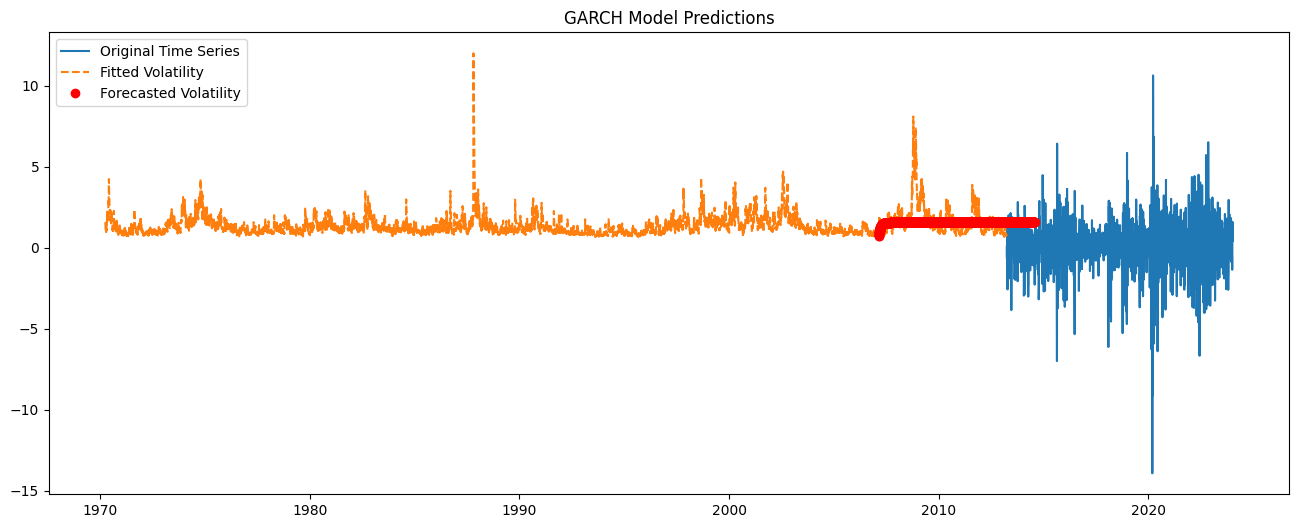

In [320]:
forecast = result.forecast(horizon= len(data_test) , start='2013-04-01')
print(forecast.variance)

forecasted_volatility = np.sqrt(forecast.variance.iloc[-1, :])

# Plot the original time series, fitted values, and forecasted volatility
plt.figure(figsize=(16, 6))
plt.plot(data_test, label='Original Time Series')
plt.plot(result.conditional_volatility, label='Fitted Volatility', linestyle='--')
plt.plot(np.arange(len(returns), len(returns) + len(data_test)), forecasted_volatility, 'ro', label='Forecasted Volatility')
#plt.plot(forecast.variance,label="Volatility")
plt.legend()
plt.title('GARCH Model Predictions')
plt.show()

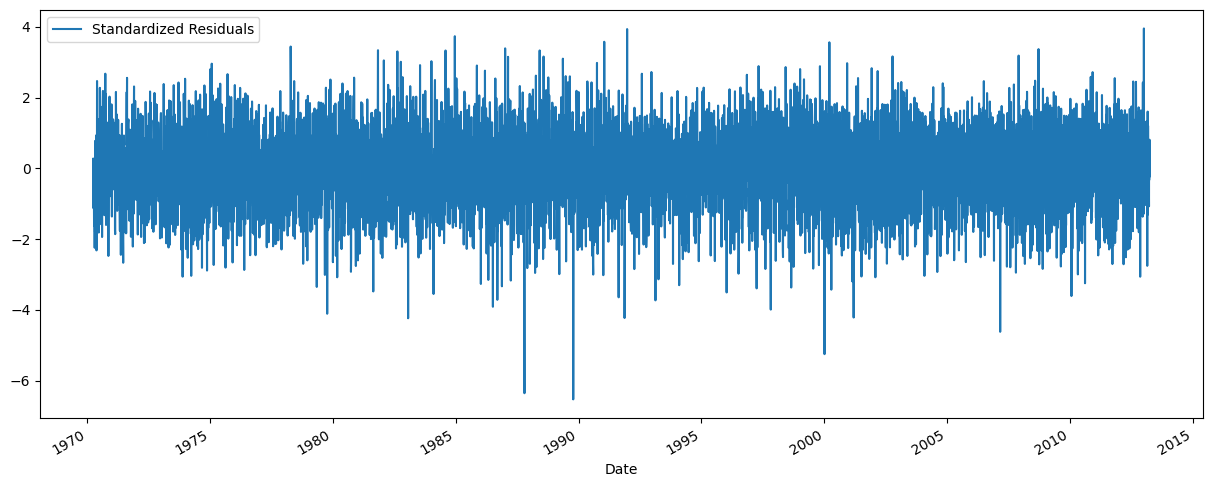

In [321]:
fig, ax = plt.subplots(figsize=(15, 6))

result.std_resid.plot(ax=ax, label='Standardized Residuals')

plt.xlabel('Date')

plt.legend()
plt.show()

In [322]:
predictions = result.forecast(horizon=100)


KeyError: 1

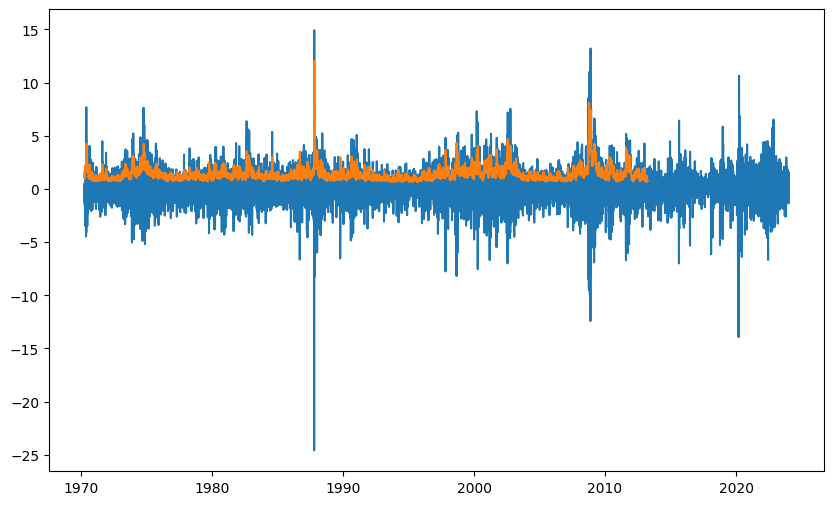

In [323]:
plt.figure(figsize=(10, 6))
plt.plot(returns, label='Original Time Series')
plt.plot(result.conditional_volatility, label='Fitted Volatility')
plt.plot(np.arange(len(returns), len(returns) + 100), predictions.variance[1], 'ro', label='Forecasted Volatility')
plt.legend()
plt.show()